## prove iris

In [7]:
import numpy as np
from scipy.linalg import block_diag
from math import factorial
from discopy import cat, monoidal
from discopy.monoidal import PRO
from discopy.tensor import Dim
from itertools import permutations as pr
import itertools as it
SEED = 420
import numpy as np; np.random.seed(SEED)
from matplotlib import pyplot as plt
from noisyopt import minimizeSPSA
from time import time 

## creazione data set e inizializzazione input

In [2]:
width, depth = 4, 2  # width and depth of the piece of chip for one word

n_photons = 2
input_modes = output_modes = [0, 1, 1, 0]

bias, weight = -0.7, 5  # bias and weight for the classical post-processing

n_iter, alpha, gamma = 100, 0.602, 0.101  # optimization, hyper-parameters

SEED = 420

In [3]:
E = [x if not i else x + str(i + 1) 
     for i in range(1) for x in ["Alice", "Bob", "Claire", "Dave", "Eve", "Fred"]]
R = ["loves", "kills", "hates"]

print("Nouns: {}".format(', '.join(E)))
print("Verbs: {}".format(', '.join(R)))

Nouns: Alice, Bob, Claire, Dave, Eve, Fred
Verbs: loves, kills, hates


108 subject-verb-object sentences:


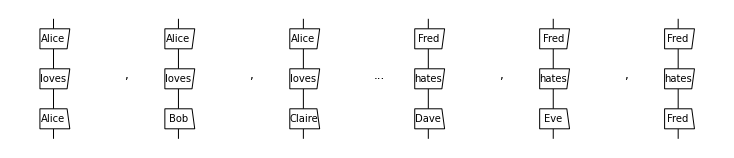

In [14]:
from discopy import Ty, Word, drawing

n = Ty('n')

class SimpleWord(Word):
    """ Word boxes with `dom == cod == n`. """
    def __init__(self, name, dom=n, cod=n, data=None, _dagger=False):
        super().__init__(name, dom=dom, cod=cod, data=data, _dagger=_dagger)

corpus = {
    ' '.join([x, r, y]):
    SimpleWord(x) >> SimpleWord(r) >> SimpleWord(y).dagger()
    for x in E for r in R for y in E}

print("{} subject-verb-object sentences:".format(len(corpus)))
start = drawing.Equation(*list(corpus.values())[:3], symbol=',')
end = drawing.Equation(*list(corpus.values())[-3:], symbol=',')
drawing.equation(start, end, symbol='...', asymmetry=5e-2, figsize=(10, 2), draw_type_labels=False)

In [ ]:
# #controllo normalizzazione
# t=[]
# modes=np.array([0,0,1,1,2,2,3,3])
# comb=set(it.combinations(modes, 2))
# combs=list(comb)
# p_bs=0
# p_dist=0
# for y in combs:
#     output=[0,0,0,0]
#     for xx in range(len(y)):
#         output[y[xx]]+=1
#     print(output)
#     p_bs=p_bs+probability(F(params0)(corpus["Alice loves Bob"]).amp(2, [0,1,1,0],output))
#     p_dist=p_dist+F(params0)(corpus["Alice loves Bob"]).amp_dist(2, [0,1,1,0],output)  
# F(params0)(corpus["Alice kills Eve"]).amp_CL(2, [0,1,1,0],[1,0,0,0])+\
# F(params0)(corpus["Alice kills Eve"]).amp_CL(2, [0,1,1,0],[0,1,0,0])+\
# F(params0)(corpus["Alice kills Eve"]).amp_CL(2, [0,1,1,0],[0,0,1,0])+\
# F(params0)(corpus["Alice kills Eve"]).amp_CL(2, [0,1,1,0],[0,0,0,1])

[1, 1, 0, 0]
[0, 1, 1, 0]
[2, 0, 0, 0]
[0, 2, 0, 0]
[1, 0, 0, 1]
[0, 0, 1, 1]
[1, 0, 1, 0]
[0, 0, 0, 2]
[0, 0, 2, 0]
[0, 1, 0, 1]


1.0

In [ ]:
# t=[]
# modes=np.array([0,0,1,1,2,2,3,3])
# comb=set(it.combinations(modes, 2))
# combs=list(comb)
# p_cl=0
# for y in combs:
#     output=[0,0,0,0]
#     for xx in range(len(y)):
#         output[y[xx]]+=1
#     print(output)
#     p_bs=p_bs+probability(F(params0)(corpus["Alice loves Bob"]).amp(2, [0,1,1,0],output))
#     p_dist=p_dist+F(params0)(corpus["Alice loves Bob"]).amp_dist(2, [0,1,1,0],output)  

p_bs

p_dist

In [17]:
#costruisce il chip

def ansatz(params):
    depth, half_width, _ = params.shape
    chip = Id(2 * half_width)
    for i in range(depth):
        chip >>= Id().tensor(*[
                MZI(*params[i, j]) for j in range(half_width)])\
            if not i % 2 else Id(1).tensor(*[
                MZI(*params[i, j]) for j in range(half_width - 1)]) @ Id(1)
    return chip

In [20]:
n_params = 2 * (depth * width // 2 - depth // 2)

random_params = lambda: np.random.uniform(size=(len(E + R), depth, width // 2, 2))

params0 = random_params()

print("Ansatz for 'Bob' ({} parameters):".format(n_params))

drawing.equation(
    SimpleWord('Bob'), ansatz(params0[1]),
    draw_type_labels=False, symbol='$\\mapsto$', figsize=(10, 4))

print("Total: {} * {} = {} parameters.".format(len(E + R), n_params, len(E + R) * n_params))
print(params0.flatten())

Ansatz for 'Bob' (6 parameters):


NameError: name 'Id' is not defined

## giro di prova

Ansatz for 'Alice loves Bob':


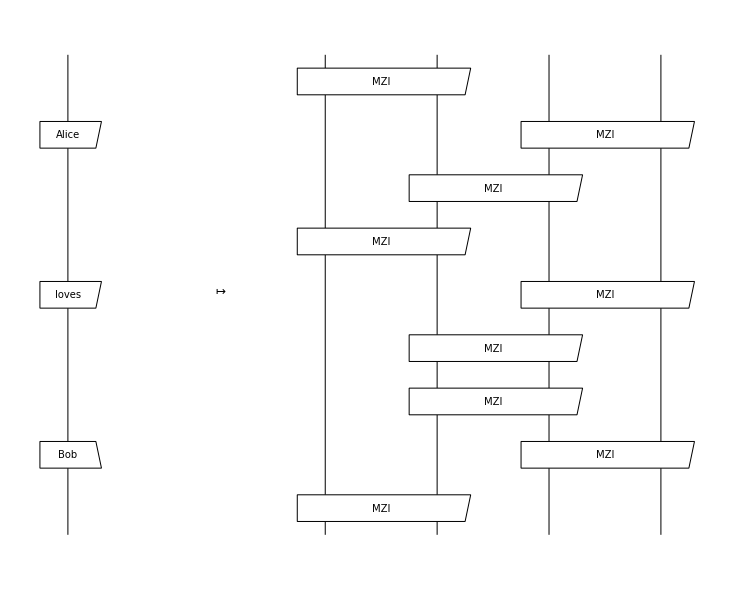

In [ ]:
F = lambda params: Functor(
    ob={n: Ty(1) ** width},
    ar={SimpleWord(w): ansatz(params[i]) for i, w in enumerate(E + R)})

F0 = F(params0)

print("Ansatz for 'Alice loves Bob':")
drawing.equation(
    corpus["Alice loves Bob"], F0(corpus["Alice loves Bob"]),
    symbol='$\\mapsto$', figsize=(10, 8), draw_type_labels=False, asymmetry=5e-2)

activation = lambda x: 1 / (1 + np.exp(-x))
post_processing = lambda x: activation(x * weight + bias)

In [ ]:
#generazione dataset con valori di true e false

probability = lambda amplitude: np.absolute(amplitude) ** 2

def evaluate(params, sentence):
    params = params.reshape(params0.shape)
    return post_processing(probability(
        F(params)(corpus[sentence]).amp(
            n_photons, input_modes, output_modes)))

print(print(params0.flatten()))

%time scores = {sentence: evaluate(params0, sentence) for sentence in corpus}

print("Does Fred love Eve? {} ({:.2F})".format(
    "Yes" if scores["Fred loves Eve"] > .5 else "No", scores["Fred loves Eve"]))

[0.15192438 0.5807287  0.18929702 ... 0.41410442 0.04911702 0.99226202]
None
Wall time: 1.69 s
Does Fred love Eve? No (0.48)


Min: 0.33 (Bob hates Alice)
Max: 0.97 (Fred hates Fred)
Mean: 0.50
Standard deviation: 0.16

40 true sentences (score > .5)


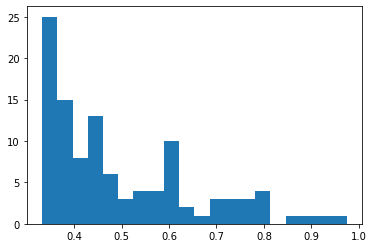

In [ ]:
X = list(scores.values())

plt.hist(X, 20)

_min, _max = min(X), max(X)
arg_min, arg_max = list(corpus)[X.index(_min)], list(corpus)[X.index(_max)]

print("Min: {:.2F} ({})".format(_min, arg_min))
print("Max: {:.2F} ({})".format(_max, arg_max))
print("Mean: {:.2F}".format(np.mean(X)))
print("Standard deviation: {:.2F}".format(np.std(X)))
print()
print("{} true sentences (score > .5)".format(sum([x > .5 for x in X])))

Does Fred love Eve? No (0.48)
Min: 0.33 (Bob hates Alice)
Max: 0.97 (Fred hates Fred)
Mean: 0.50
Standard deviation: 0.16

40 true sentences (score > .5)


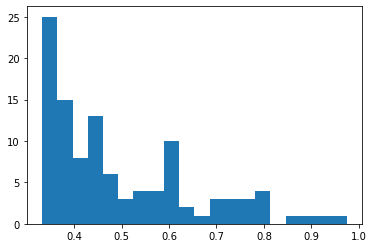

In [ ]:
#evaluation per fotoni distinguibili

def evaluate_dist(params, sentence):
    params = params.reshape(params0.shape)
    return post_processing(
        F(params)(corpus[sentence]).amp_dist(
            n_photons, input_modes, output_modes))

#%time scores = {sentence: evaluate_dist(params0, sentence) for sentence in corpus}

print("Does Fred love Eve? {} ({:.2F})".format(
    "Yes" if scores["Fred loves Eve"] > .5 else "No", scores["Fred loves Eve"]))

X = list(scores.values())

plt.hist(X, 20)

_min, _max = min(X), max(X)
arg_min, arg_max = list(corpus)[X.index(_min)], list(corpus)[X.index(_max)]

print("Min: {:.2F} ({})".format(_min, arg_min))
print("Max: {:.2F} ({})".format(_max, arg_max))
print("Mean: {:.2F}".format(np.mean(X)))
print("Standard deviation: {:.2F}".format(np.std(X)))
print()
print("{} true sentences (score > .5)".format(sum([x > .5 for x in X])))

Does Fred love Eve? No (0.48)
Min: 0.33 (Bob hates Alice)
Max: 0.97 (Fred hates Fred)
Mean: 0.50
Standard deviation: 0.16

40 true sentences (score > .5)


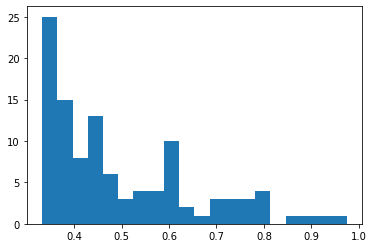

In [ ]:
#evaluation per luce classica (fasci che non interferiscono)

params0 = random_params()

def evaluate_CL(params, sentence):
    params = params.reshape(params0.shape)
    return post_processing(
        F(params)(corpus[sentence]).amp_CL(
            n_photons, input_modes, output_modes))

#%time scores = {sentence: evaluate_CL(params0, sentence) for sentence in corpus}

print("Does Fred love Eve? {} ({:.2F})".format(
    "Yes" if scores["Fred loves Eve"] > .50 else "No", scores["Fred loves Eve"]))
X = list(scores.values())

plt.hist(X, 20)

_min, _max = min(X), max(X)
arg_min, arg_max = list(corpus)[X.index(_min)], list(corpus)[X.index(_max)]

print("Min: {:.2F} ({})".format(_min, arg_min))
print("Max: {:.2F} ({})".format(_max, arg_max))
print("Mean: {:.2F}".format(np.mean(X)))
print("Standard deviation: {:.2F}".format(np.std(X)))
print()
print("{} true sentences (score > .5)".format(sum([x > .5 for x in X])))

## ottimizzazione 

In [ ]:
## separazione training set e testing set

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

dataset = {sentence: int(score > .5) for sentence, score in scores.items()}

train, test = train_test_split(list(corpus), test_size=1 / 3, random_state=42)

print("Training set:\n{}\n{}".format('\n'.join(train[:3]), '...\n' if len(train) > 3 else ''))
print("Testing set:\n{}\n{}".format('\n'.join(test[:3]), '...\n' if len(test) > 3 else ''))

Training set:
Bob kills Eve
Claire loves Eve
Alice loves Fred
...

Testing set:
Eve loves Fred
Alice kills Eve
Alice loves Eve
...



In [ ]:
def loss(corpus, params, mode):
    if mode=='bs':
        return mean_squared_error(*zip(*[
        (dataset[sentence], evaluate(params, sentence))
        for sentence in corpus]))
    if mode=='dist':
        return mean_squared_error(*zip(*[
        (dataset[sentence], evaluate_dist(params, sentence))
        for sentence in corpus]))
    if mode=='cl':
        return mean_squared_error(*zip(*[
        (dataset[sentence], evaluate_CL(params, sentence))
        for sentence in corpus]))

testing_loss = lambda params: loss(test, params, 'bs')
training_loss = lambda params: loss(train, params, 'bs')

params_in = random_params().flatten()
params= params_in.copy()

print("Random initialisation, training_loss: {:.3f}, testing loss: {:.3f}".format(
    training_loss(params), testing_loss(params)))
print(params)
print()
print("Does Fred love Eve?")
print("Yes" if evaluate(params, 'Fred loves Eve') > .5 else "No")

Random initialisation, training_loss: 0.282, testing loss: 0.243
[0.64004512 0.82792698 0.13086325 ... 0.75013443 0.57627137 0.58343567]

Does Fred love Eve?
No


In [ ]:
params_in

array([0.64004512, 0.82792698, 0.13086325, ..., 0.75013443, 0.57627137,
       0.58343567])

In [ ]:
params=params_in.copy()
print(params)

training_losses, testing_losses = [], []
start = time()
def callback(params):
    training_losses.append(training_loss(params))
    testing_losses.append(testing_loss(params))
    if not len(training_losses) % (n_iter // 10) or len(training_losses) < 10:
        print("Iteration {}, training_loss: {:.3f}, testing loss: {:.3f}".format(
            len(training_losses), training_losses[-1], testing_losses[-1]))
        print(params)
        print()

result = minimizeSPSA(training_loss, params, paired=False, callback=callback, niter=400, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)

print("Does Alice love Bob?")
print("Yes" if evaluate(result.x, 'Alice loves Bob') > .5 else "No")
print("time taken", time()-start)

[0.64004512 0.82792698 0.13086325 ... 0.75013443 0.57627137 0.58343567]
Iteration 1, training_loss: 0.277, testing loss: 0.240
[0.66710297 0.80086913 0.1038054  ... 0.72307658 0.54921352 0.61049351]

Iteration 2, training_loss: 0.277, testing loss: 0.239
[0.66859028 0.80235644 0.1023181  ... 0.72158927 0.54772621 0.61198082]

Iteration 3, training_loss: 0.276, testing loss: 0.247
[0.68249956 0.81626572 0.11622738 ... 0.73549855 0.56163549 0.59807154]

Iteration 4, training_loss: 0.275, testing loss: 0.247
[0.67478956 0.82397572 0.12393738 ... 0.72778855 0.55392549 0.60578154]

Iteration 5, training_loss: 0.277, testing loss: 0.237
[0.69551496 0.80325032 0.10321198 ... 0.74851395 0.53320009 0.62650694]

Iteration 6, training_loss: 0.276, testing loss: 0.235
[0.68540416 0.81336111 0.09310118 ... 0.75862475 0.52308929 0.61639615]

Iteration 7, training_loss: 0.275, testing loss: 0.240
[0.69781298 0.8009523  0.10551    ... 0.74621593 0.53549811 0.60398733]

Iteration 8, training_loss: 0.27

In [ ]:
print("Does Fred love Eve?")
print("Yes" if evaluate(result.x, 'Fred loves Eve') > .5 else "No")
print("time taken", time()-start)


Does Fred love Eve?
No
time taken 1531.7049267292023


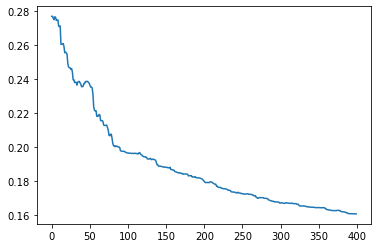

In [ ]:
plt.plot(training_losses)

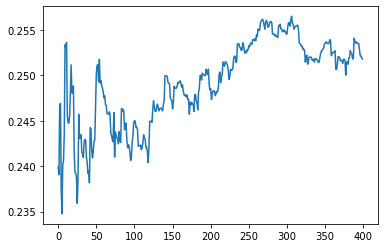

In [ ]:
plt.plot(testing_losses)

In [ ]:
testing_loss_dist = lambda params: loss(test, params, 'dist')
training_loss_dist = lambda params: loss(train, params, 'dist')

params=params_in.copy()

training_losses_dist, testing_losses_dist = [], []
start = time()
def callback_dist(params):
    training_losses_dist.append(training_loss_dist(params))
    testing_losses_dist.append(testing_loss_dist(params))
    if not len(training_losses_dist) % (n_iter // 10) or len(training_losses_dist) < 10:
        print("Iteration {}, training_loss: {:.3f}, testing loss: {:.3f}".format(
            len(training_losses_dist), training_losses_dist[-1], testing_losses_dist[-1]))
        print(params)
        print()

result_dist = minimizeSPSA(training_loss_dist, params, paired=False, callback=callback_dist, niter=100, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)

#print("Does Alice love Bob?")
#print("Yes" if evaluate_dist(result_dist.x, 'Alice loves Bob') > .5 else "No")
#print("time taken", time()-start)

Iteration 1, training_loss: 0.289, testing loss: 0.226
[0.63446387 0.82234573 0.1364445  ... 0.75571568 0.57069012 0.58901691]

Iteration 2, training_loss: 0.289, testing loss: 0.227
[0.63577324 0.82103637 0.13775387 ... 0.75440631 0.57199949 0.59032628]

Iteration 3, training_loss: 0.288, testing loss: 0.246
[0.65619411 0.84145723 0.117333   ... 0.73398544 0.59242036 0.61074715]

Iteration 4, training_loss: 0.285, testing loss: 0.250
[0.63906212 0.82432525 0.10020102 ... 0.75111743 0.60955234 0.59361516]

Iteration 5, training_loss: 0.285, testing loss: 0.251
[0.63418365 0.82920372 0.10507949 ... 0.7559959  0.61443081 0.58873669]

Iteration 6, training_loss: 0.271, testing loss: 0.253
[0.67360281 0.86862289 0.14449865 ... 0.71657674 0.57501165 0.62815585]

Iteration 7, training_loss: 0.268, testing loss: 0.256
[0.69304511 0.84918059 0.12505636 ... 0.73601903 0.59445394 0.64759815]

Iteration 8, training_loss: 0.267, testing loss: 0.243
[0.71072754 0.83149816 0.10737392 ... 0.75370147 

In [ ]:
testing_loss_cl = lambda params: loss(test, params, 'cl')
training_loss_cl = lambda params: loss(train, params, 'cl')

params=params_in.copy()

training_losses_cl, testing_losses_cl = [], []
start = time()
def callback_cl(params):
    training_losses_cl.append(training_loss_cl(params))
    testing_losses_cl.append(testing_loss_cl(params))

    if not len(training_losses_cl) % (n_iter // 10) or len(training_losses_cl) < 10:
        print("Iteration {}, training_loss: {:.3f}, testing loss: {:.3f}".format(
            len(training_losses_cl), training_losses_cl[-1], testing_losses_cl[-1]))
        print(params)
        print()

result_cl = minimizeSPSA(training_loss_cl, params, paired=False, callback=callback_cl, niter=100, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)

#print("Does Alice love Bob?")
#print("Yes" if evaluate_cl(result_cl.x, 'Alice loves Bob') > .5 else "No")
#print("time taken", time()-start)

Iteration 1, training_loss: 0.457, testing loss: 0.475
[0.68617847 0.78179363 0.17699661 ... 0.70400108 0.53013801 0.53730231]

Iteration 2, training_loss: 0.457, testing loss: 0.472
[0.71378678 0.75418532 0.1493883  ... 0.73160939 0.55774632 0.509694  ]

Iteration 3, training_loss: 0.455, testing loss: 0.476
[0.72095082 0.76134935 0.15655233 ... 0.73877342 0.55058229 0.51685804]

Iteration 4, training_loss: 0.451, testing loss: 0.480
[0.73543548 0.74686469 0.17103699 ... 0.72428876 0.53609763 0.50237338]

Iteration 5, training_loss: 0.451, testing loss: 0.480
[0.73709523 0.74852444 0.16937724 ... 0.72594851 0.53775738 0.50071363]

Iteration 6, training_loss: 0.448, testing loss: 0.491
[0.719156   0.73058521 0.15143801 ... 0.74388775 0.51981814 0.51865286]

Iteration 7, training_loss: 0.443, testing loss: 0.497
[0.70022203 0.74951917 0.13250404 ... 0.72495379 0.53875211 0.4997189 ]

Iteration 8, training_loss: 0.442, testing loss: 0.496
[0.71350249 0.76279963 0.11922359 ... 0.71167333 

In [ ]:
print("Does Fred love Eve?")

print("Yes" if evaluate(result_dist.x, 'Fred loves Eve') > .5 else "No")
print("time taken", time()-start)

Does Fred love Eve?
No
time taken 1716.1423156261444


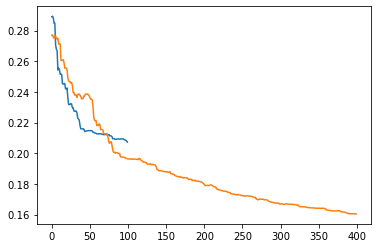

In [ ]:
plt.plot(training_losses_dist)
# plt.plot(training_losses_cl)
plt.plot(training_losses)

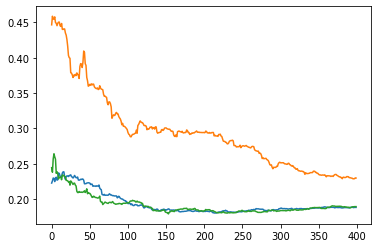

In [ ]:
plt.plot(testing_losses_dist)
plt.plot(testing_losses_cl)
plt.plot(testing_losses)

In [ ]:
testing_loss_cl = lambda params: loss(test, params, 'cl')
training_loss_cl = lambda params: loss(train, params, 'cl')

params=params_in.copy()
print(params)
training_losses_cl, testing_losses_cl = [], []
start = time()
def callback_cl(params):
    training_losses_cl.append(training_loss_cl(params))
    testing_losses_cl.append(testing_loss_cl(params))
    if not len(training_losses_cl) % (n_iter // 10) or len(training_losses_cl) < 10:
        print("Iteration {}, training_loss: {:.3f}, testing loss: {:.3f}".format(
            len(training_losses_cl), training_losses_cl[-1], testing_losses_cl[-1]))
        print(params)
        print()

#result_cl = minimizeSPSA(training_loss_cl, params, paired=False, callback=callback_cl, niter=400, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)

#print("Does Alice love Bob?")
#print("Yes" if evaluate_CL(result_cl.x, 'Alice loves Bob') > .5 else "No")
#print("time taken", time()-start)

[0.04689655 0.14173987 0.25197844 ... 0.7641264  0.50990268 0.93593863]


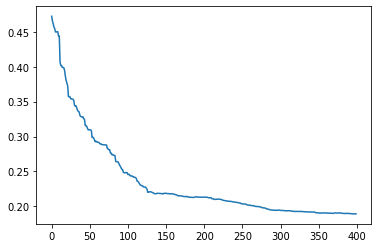

In [ ]:
plt.plot(training_losses_cl)

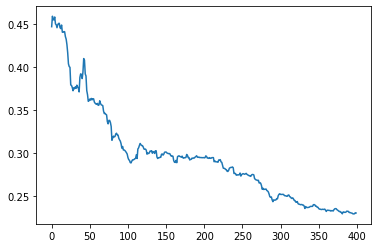

In [ ]:
plt.plot(testing_losses_cl)

In [ ]:
#bs
from sklearn.metrics import classification_report

y_train_true = [dataset[sentence] for sentence in train]
y_train_pred = [evaluate(result.x, sentence) > .5 for sentence in train]

print(classification_report(y_train_true, y_train_pred))

y_test_true = [dataset[sentence] for sentence in test]
y_test_pred = [evaluate(result.x, sentence) > .5 for sentence in test]

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        48
           1       0.91      0.83      0.87        24

    accuracy                           0.92        72
   macro avg       0.91      0.90      0.90        72
weighted avg       0.92      0.92      0.92        72

              precision    recall  f1-score   support

           0       0.79      0.68      0.73        22
           1       0.59      0.71      0.65        14

    accuracy                           0.69        36
   macro avg       0.69      0.70      0.69        36
weighted avg       0.71      0.69      0.70        36



In [ ]:
#dist
y_train_true = [dataset[sentence] for sentence in train]
y_train_pred = [evaluate_dist(result_dist.x, sentence) > .5 for sentence in train]

print(classification_report(y_train_true, y_train_pred))

y_test_true = [dataset[sentence] for sentence in test]
y_test_pred = [evaluate_dist(result_dist.x, sentence) > .5 for sentence in test]

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94        48
           1       0.95      0.79      0.86        24

    accuracy                           0.92        72
   macro avg       0.93      0.89      0.90        72
weighted avg       0.92      0.92      0.91        72

              precision    recall  f1-score   support

           0       0.83      0.86      0.84        22
           1       0.77      0.71      0.74        14

    accuracy                           0.81        36
   macro avg       0.80      0.79      0.79        36
weighted avg       0.80      0.81      0.80        36



In [ ]:
#cl
from sklearn.metrics import classification_report
y_train_true = [dataset[sentence] for sentence in train]
y_train_pred = [evaluate_CL(result_cl.x, sentence) > .5 for sentence in train]

print(classification_report(y_train_true, y_train_pred))

y_test_true = [dataset[sentence] for sentence in test]
y_test_pred = [evaluate_CL(result_cl.x, sentence) > .5 for sentence in test]

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        48
           1       0.75      0.50      0.60        24

    accuracy                           0.78        72
   macro avg       0.77      0.71      0.72        72
weighted avg       0.77      0.78      0.76        72

              precision    recall  f1-score   support

           0       0.73      0.73      0.73        22
           1       0.57      0.57      0.57        14

    accuracy                           0.67        36
   macro avg       0.65      0.65      0.65        36
weighted avg       0.67      0.67      0.67        36



## Average

In [ ]:
params_in

array([0.04689655, 0.14173987, 0.25197844, ..., 0.7641264 , 0.50990268,
       0.93593863])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_train_true = []
y_test_true = []
y_train_pred = []
y_train_pred_dist = []
y_train_pred_cl = []
y_test_pred = []
y_test_pred_dist = []
y_test_pred_cl = []

def callback(params):
    training_losses.append(training_loss(params))
    testing_losses.append(testing_loss(params))
def callback_cl(params):
    training_losses_cl.append(training_loss_cl(params))
    testing_losses_cl.append(testing_loss_cl(params))
def callback_dist(params):
    training_losses_dist.append(training_loss_dist(params))
    testing_losses_dist.append(testing_loss_dist(params))
    
n_prove=5


for index in range(n_prove):
    print("giro # %d di %d" %(index+1, n_prove))
    training_losses_cl, testing_losses_cl = [], []
    training_losses, testing_losses= [], []
    training_losses_dist, testing_losses_dist = [], []
    y_train_true = y_train_true+[dataset[sentence] for sentence in train]
    y_test_true =y_test_true+[dataset[sentence] for sentence in test]
    print(params_in)
    params= params_in.copy()
    result = minimizeSPSA(training_loss, params, paired=False, callback=callback_dist, niter=400, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)
    y_train_pred = y_train_pred+[evaluate(result.x, sentence) > .5 for sentence in train]
    y_test_pred = y_test_pred+[evaluate(result.x, sentence) > .5 for sentence in test]
    print("bs case train ", classification_report(y_train_true, y_train_pred))
    print("bs case test ", classification_report(y_test_true, y_test_pred))
    params= params_in.copy()
    result_cl = minimizeSPSA(training_loss_cl, params, paired=False, callback=callback_cl, niter=400, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)
    y_train_pred_cl = y_train_pred_cl+[evaluate_CL(result_cl.x, sentence) > .5 for sentence in train]
    y_test_pred_cl = y_test_pred_cl+[evaluate_CL(result_cl.x, sentence) > .5 for sentence in test]
    print("cl case train ", classification_report(y_train_true, y_train_pred_cl))
    print("cl case test ", classification_report(y_test_true, y_test_pred_cl))
    params= params_in.copy()
    result_dist = minimizeSPSA(training_loss_dist, params, paired=False, callback=callback_dist, niter=400, a = 0.5, alpha=alpha, c= 0.1, gamma=gamma)
    y_train_pred_dist = y_train_pred_dist+[evaluate_dist(result_dist.x, sentence) > .5 for sentence in train]
    y_test_pred_dist = y_test_pred_dist+[evaluate_dist(result_dist.x, sentence) > .5 for sentence in test]
    print("dist case train ", classification_report(y_train_true, y_train_pred_dist))
    print("dist case test ", classification_report(y_test_true, y_test_pred_dist))
    params_in = random_params().flatten()
    
    



giro # 1 di 5
[0.04689655 0.14173987 0.25197844 ... 0.7641264  0.50990268 0.93593863]
bs case train                precision    recall  f1-score   support

           0       0.82      0.98      0.90        48
           1       0.93      0.58      0.72        24

    accuracy                           0.85        72
   macro avg       0.88      0.78      0.81        72
weighted avg       0.86      0.85      0.84        72

bs case test                precision    recall  f1-score   support

           0       0.82      0.82      0.82        22
           1       0.71      0.71      0.71        14

    accuracy                           0.78        36
   macro avg       0.77      0.77      0.77        36
weighted avg       0.78      0.78      0.78        36

cl case train                precision    recall  f1-score   support

           0       0.79      0.96      0.87        48
           1       0.86      0.50      0.63        24

    accuracy                           0.81        7

KeyboardInterrupt: 

In [ ]:
file_bs_test=open("y_test_true_bs.txt", "wb")
file_bs_train=open("y_train_true_bs.txt", "wb")
file_dist_test=open("y_test_true_dist.txt", "wb")
file_dist_train=open("y_train_true_dist.txt", "wb")
file_cl_test=open("y_test_true_cl.txt", "wb")
file_cl_train=open("y_train_true_cl.txt", "wb")

In [ ]:
import pickle
pickle.dump(y_test_pred_bs, file_bs_test)
pickle.dump(y_train_pred_bs, file_bs_train)
pickle.dump(y_test_pred_bs, file_dist_test)
pickle.dump(y_train_pred_bs, file_dist_train)
pickle.dump(y_test_pred_bs, file_cl_test)
pickle.dump(y_train_pred_bs, file_cl_train)